## Лекція 47: Авторегресійний аналіз. Часові ряди.

## Завдання

Протестуйте описані в лекції методи і моделі на датасеті AirPassengers, що міститься на GitHub в папці лекції та містить дані про коливання кількості пасажирів авіаліній із часом. 

Порівняйте метрики оцінки моделі для двох датасетів.

In [152]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sa
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

### Датасет  з домашнього завдання `AirPassengers`

In [153]:
# Завантажуємо датасет AirPassengers

series = pd.read_csv('AirPassengers.csv')
series.rename(columns={'Month': 'month','#Passengers': 'passengers'}, inplace=True)
series.head()

,month,passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


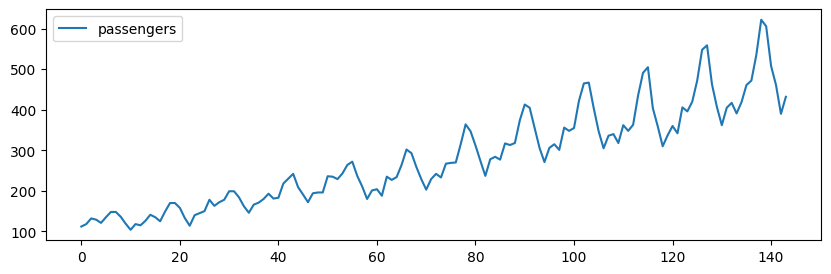

In [154]:
# Візуалізуємо дані з нашого датасету

matplotlib.rcParams['figure.figsize'] = [10, 3]
series.plot()
pyplot.show()

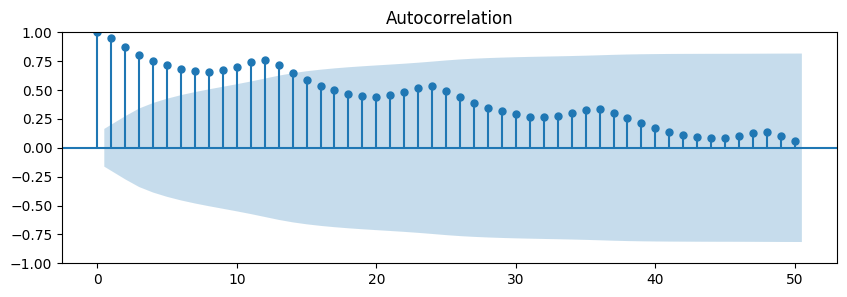

In [155]:
# Досліджуємо автокореляцію наших даних в полі passengers
plot_acf(series.passengers, lags=50)
plt.show()

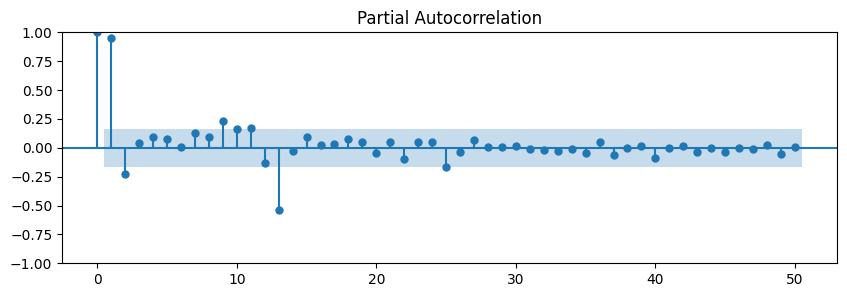

In [156]:
# Досліджуємо часткову автокореляцію наших даних в полі passengers
plot_pacf(series.passengers, method='ywm', lags=50)
plt.show()

In [157]:
# Розбиваємо наші дані та тренувальну і тестову частини
train = series.iloc[:-24]
test = series.iloc[-24:]

# Для тренування моделі використаємо модель ARIMA та визначаємо оптимальні параметри моделі
model_to_select = auto_arima(train.passengers, seasonal=True,
                   stepwise=False, trace=True, m=12)
print(model_to_select.summary())

 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=910.236, Time=0.02 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=912.235, Time=0.12 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=914.228, Time=0.20 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=912.235, Time=0.19 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=914.235, Time=0.28 sec
 ARIMA(0,0,0)(1,1,2)[12] intercept   : AIC=916.229, Time=0.73 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=914.224, Time=0.51 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=916.133, Time=1.17 sec
 ARIMA(0,0,0)(2,1,2)[12] intercept   : AIC=inf, Time=1.91 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=859.115, Time=0.08 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=860.575, Time=0.24 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=862.422, Time=0.65 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=860.629, Time=0.27 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=862.453, Time=0.64 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=864.421, Time=0.76 sec
 ARIMA(0,0,1)(

##### Best model:  ARIMA(2,0,0)(1,1,2)[12]

In [158]:
# Тренуємо нашу модель і робимо прогноз на тестовий період
model = ARIMA(train['passengers'], order=(2,0,0), seasonal_order=(1,1,2,12)).fit()
forecast = model.forecast(len(test), alpha=0.05)

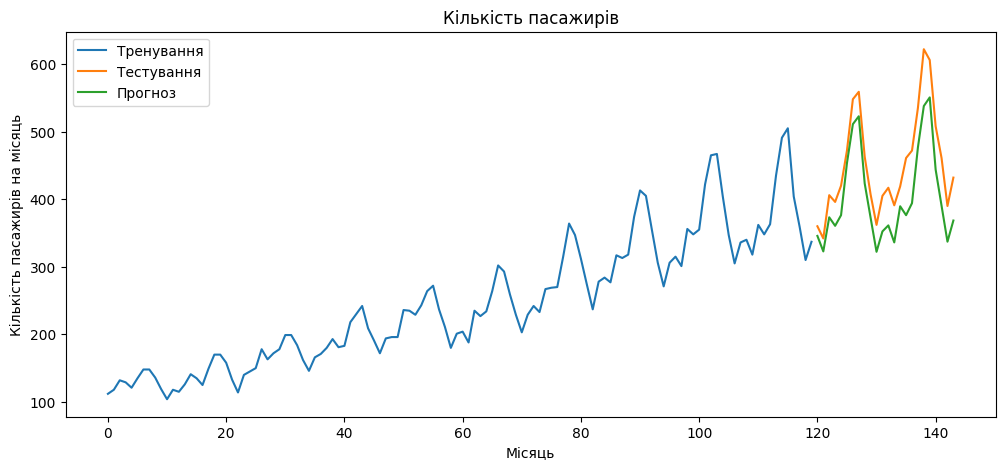

In [159]:
# Візуалізуємо отримані дані

plt.figure(figsize=(12,5))
sns.lineplot(train.passengers, label='Тренування')
sns.lineplot(test.passengers, label='Тестування')
sns.lineplot(x= test.index, y=forecast, label='Прогноз')
plt.xlabel('Місяць')
plt.ylabel('Кількість пасажирів на місяць')
plt.title('Кількість пасажирів')
plt.legend()
plt.show()

In [160]:
# Обчислюємо метрики для тренувальної частини

mae_train_b = mean_absolute_error(train['passengers'], model.fittedvalues)
rmse_train_b = np.sqrt(mean_squared_error(train['passengers'], model.fittedvalues))
mape_train_b = mean_absolute_percentage_error(train['passengers'], model.fittedvalues)

print(f'MAE train: {mae_train_b: .2f}\n'
      f'RMSE train: {rmse_train_b: .2f}\n'
      f'MAPE train:{mape_train_b: .2f}')

MAE train:  19.11
RMSE train:  41.14
MAPE train: 0.13


In [161]:
# Обчислюємо метрики для тестувальної частини

mae_test_b = mean_absolute_error(test['passengers'], forecast)
rmse_test_b = np.sqrt(mean_squared_error(test['passengers'], forecast))
mape_test_b = mean_absolute_percentage_error(test['passengers'], forecast)

print(f'MAE test: {mae_test_b: .2f}\n'
      f'RMSE test: {rmse_test_b: .2f}\n'
      f'MAPE test:{mape_test_b: .2f}')

MAE test:  48.13
RMSE test:  51.89
MAPE test: 0.11


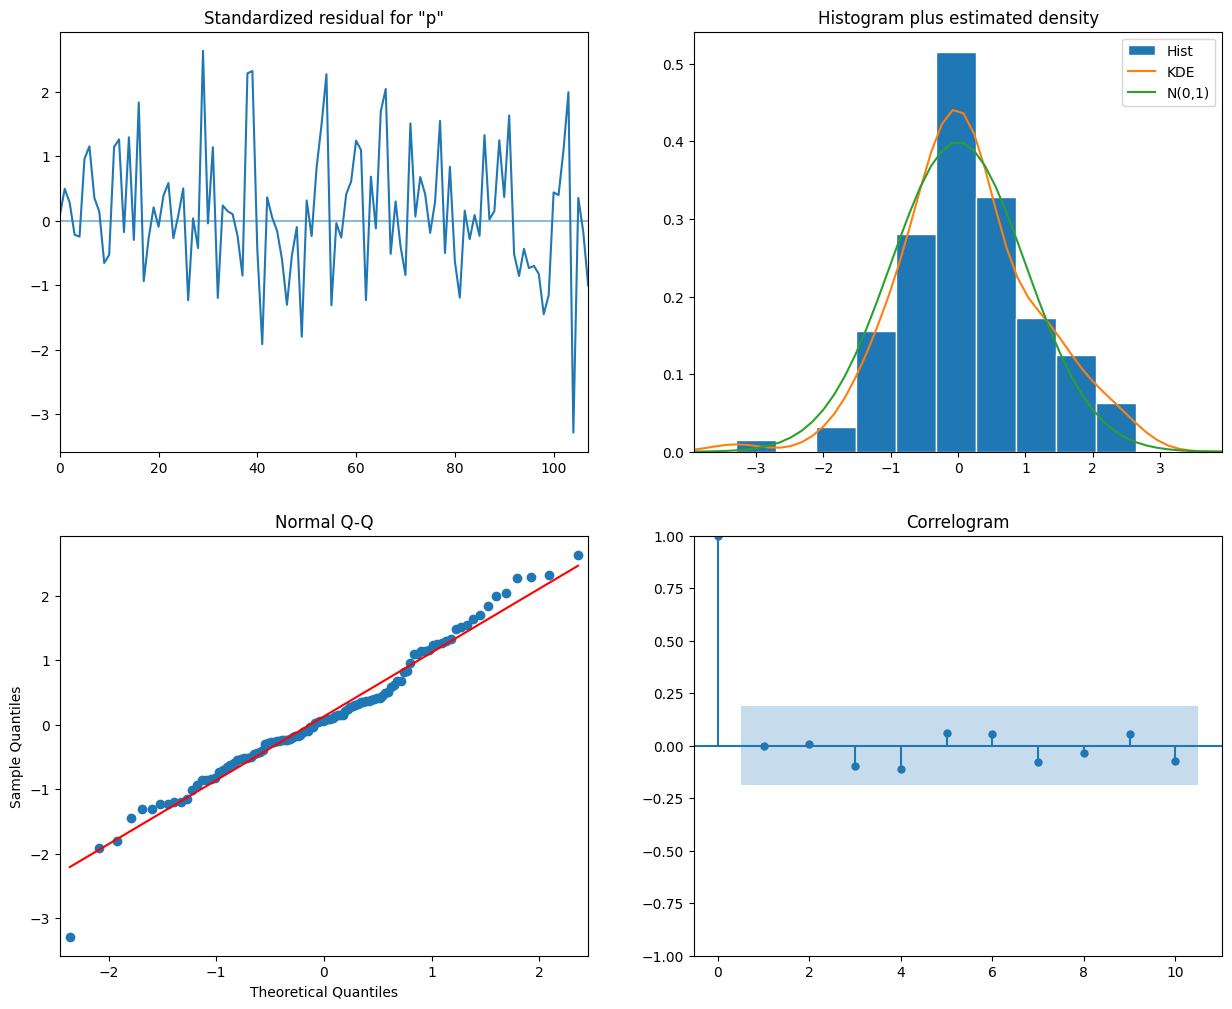

In [162]:
# Оцінимо нашу модель за допомогою графіків

fig = model.plot_diagnostics(figsize=(15,12))

In [163]:
# Використаємо модель SARIMAX для того-ж датасету AirPassengers
# Розбиваємо наші дані та тренувальну і тестову частини

train = series.iloc[:-24]
test = series.iloc[-24:]

# Тренуємо нашу модель
model_sarimax = sa.tsa.statespace.SARIMAX(train['passengers'], seasonal_order=(1,1,2,12)).fit()

In [164]:
# Робимо прогноз на тестовий період
forecast1 = model_sarimax.forecast(len(test), alpha=0.05)

In [165]:
# Обчислюємо метрики для тренувальної частини

mae_train_b = mean_absolute_error(train['passengers'], model_sarimax.fittedvalues)
rmse_train_b = np.sqrt(mean_squared_error(train['passengers'], model_sarimax.fittedvalues))
mape_train_b = mean_absolute_percentage_error(train['passengers'], model_sarimax.fittedvalues)

print(f'MAE train: {mae_train_b: .2f}\n'
      f'RMSE train: {rmse_train_b: .2f}\n'
      f'MAPE train:{mape_train_b: .2f}')

MAE train:  19.63
RMSE train:  41.24
MAPE train: 0.13


In [166]:
# Обчислюємо метрики для тестувальної частини

mae_test_b = mean_absolute_error(test['passengers'], forecast1)
rmse_test_b = np.sqrt(mean_squared_error(test['passengers'], forecast1))
mape_test_b = mean_absolute_percentage_error(test['passengers'], forecast1)

print(f'MAE test: {mae_test_b: .2f}\n'
      f'RMSE test: {rmse_test_b: .2f}\n'
      f'MAPE test:{mape_test_b: .2f}')

MAE test:  48.45
RMSE test:  52.10
MAPE test: 0.11


<AxesSubplot: >

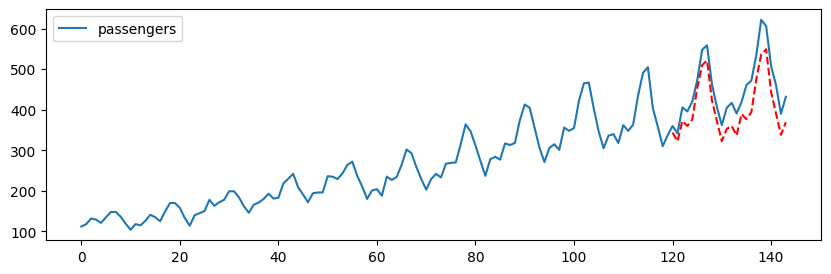

In [167]:
# Візуалізуємо отримані дані (Способ 1)

series.plot()
forecast1.plot(style='r--')

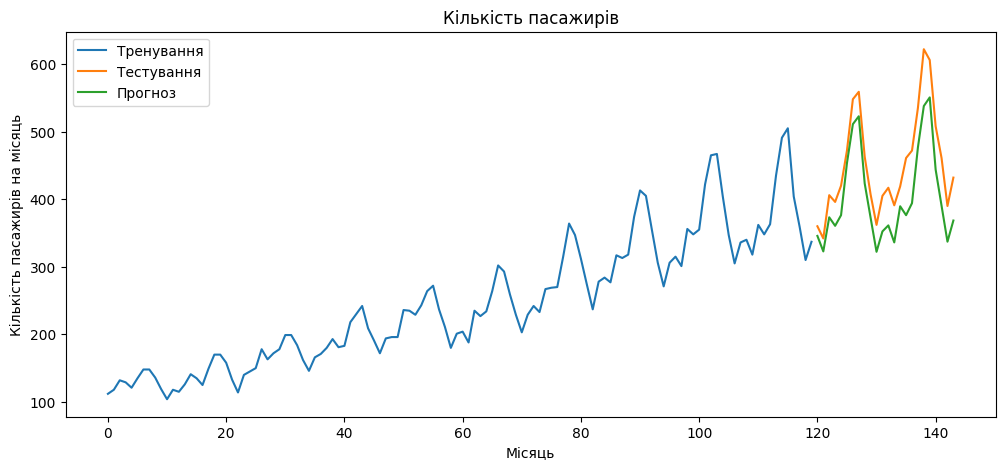

In [168]:
# Візуалізуємо отримані дані (Способ 2)

plt.figure(figsize=(12,5))
sns.lineplot(train.passengers, label='Тренування')
sns.lineplot(test.passengers, label='Тестування')
sns.lineplot(x= test.index, y=forecast, label='Прогноз')
plt.xlabel('Місяць')
plt.ylabel('Кількість пасажирів на місяць')
plt.title('Кількість пасажирів')
plt.legend()
plt.show()

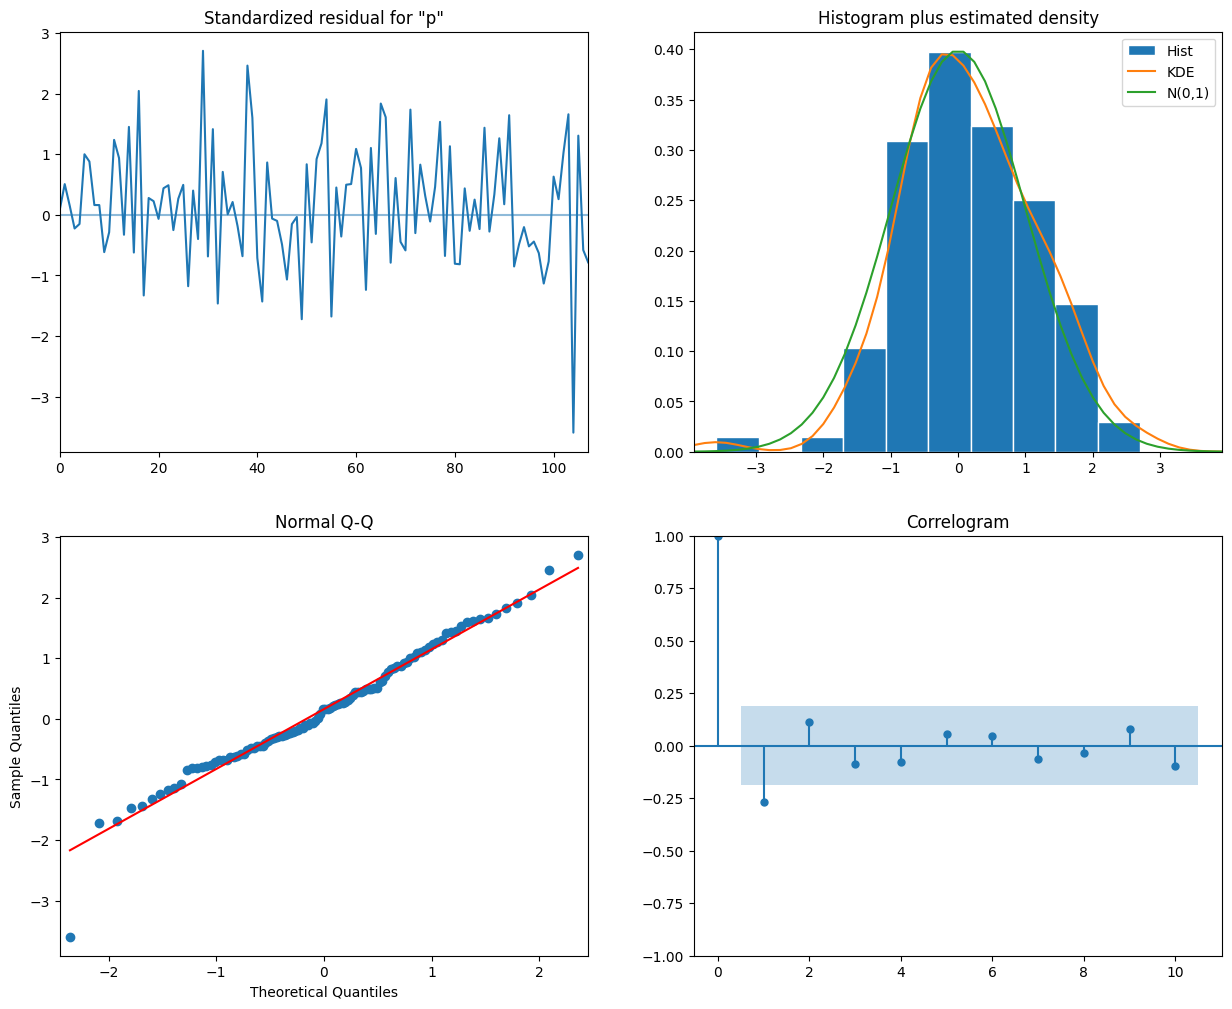

In [169]:
# Оцінимо нашу модель за допомогою графіків

fig = model_sarimax.plot_diagnostics(figsize=(15,12))

##### Робимо прогноз на 3 роки використовуючи модель ARIMA

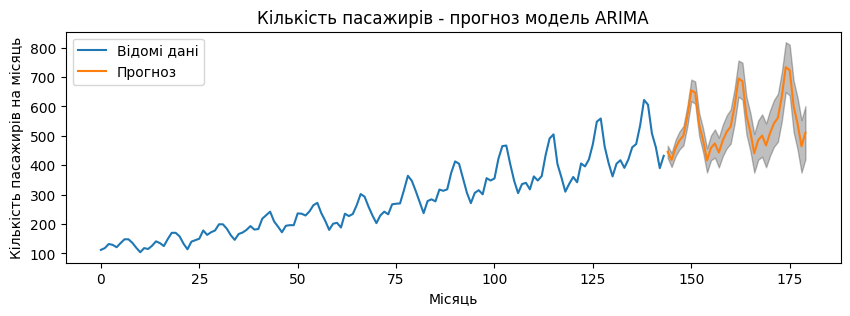

In [170]:
# Тренуємо нашу модель на основі всього датасету
model_arima = ARIMA(series['passengers'], order=(2,0,0), seasonal_order=(1,1,2,12)).fit()

pred_uc = model_arima.get_forecast(steps=12*3)
pred_ci = pred_uc.conf_int()

ax = series['passengers'].plot(label='Відомі дані')
pred_uc.predicted_mean.plot(ax=ax, label='Прогноз')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Місяць')
ax.set_ylabel('Кількість пасажирів на місяць')

plt.title('Кількість пасажирів - прогноз модель ARIMA')
plt.legend()
plt.show()

##### Робимо прогноз на 3 роки використовуючи модель SARIMAX

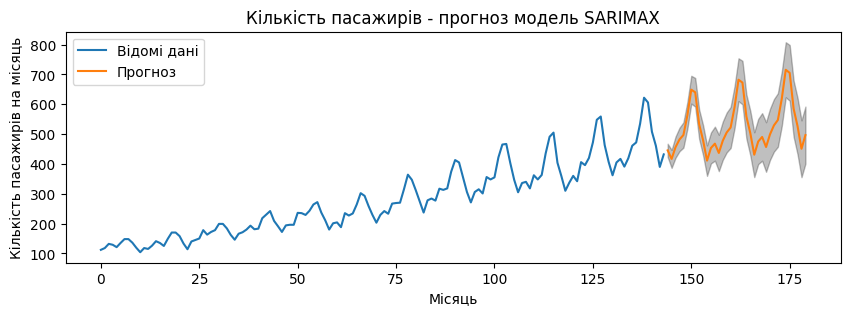

In [171]:
# Тренуємо нашу модель на основі всього датасету
model_sarimax_f = sa.tsa.statespace.SARIMAX(series['passengers'], seasonal_order=(1,1,2,12)).fit()

pred_uc = model_sarimax_f.get_forecast(steps=12*3)
pred_ci = pred_uc.conf_int()

ax = series['passengers'].plot(label='Відомі дані')
pred_uc.predicted_mean.plot(ax=ax, label='Прогноз')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Місяць')
ax.set_ylabel('Кількість пасажирів на місяць')

plt.title('Кількість пасажирів - прогноз модель SARIMAX')
plt.legend()
plt.show()

### Датасет  з лекції `temperature`

In [172]:
# Завантажуємо датасет
series1 = pd.read_csv('temperature.csv')
series1.rename(columns={'Date': 'date', 'Temp': 'temp'}, inplace=True)
series1.head()

,date,temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


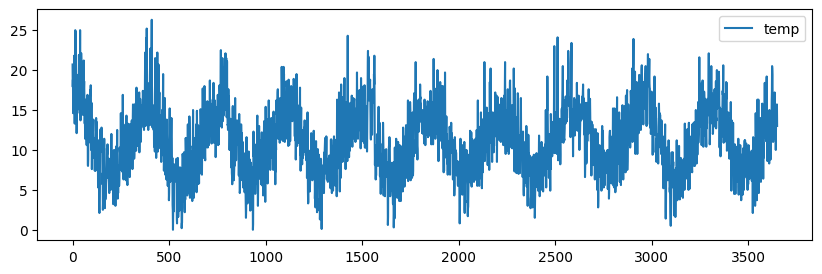

In [173]:
# Візуалізація 1

matplotlib.rcParams['figure.figsize'] = [10, 3]
series1.plot()
pyplot.show()

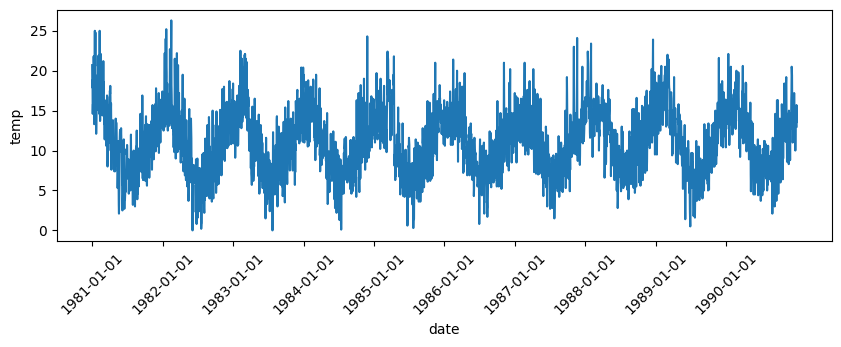

In [174]:
# Візуалізація 2

sns.lineplot(data=series1, x='date', y='temp')
plt.xticks(series1.date[::365], rotation=45)
plt.show()

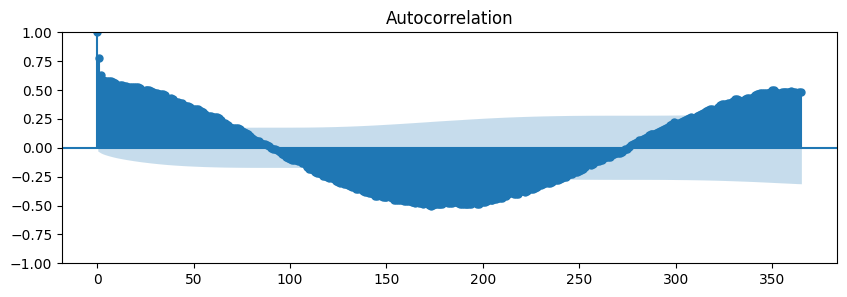

In [176]:
plot_acf(series1.temp, lags=365)
plt.show()

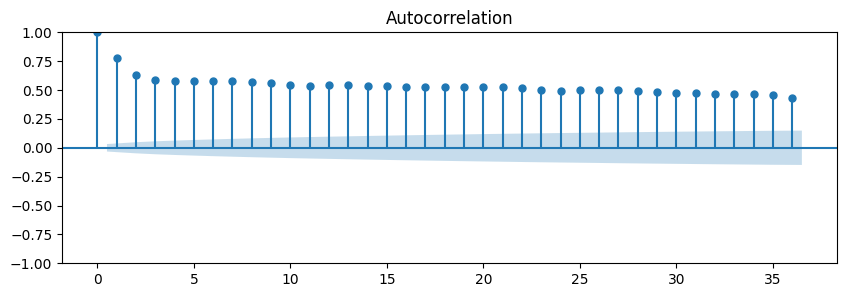

In [177]:
matplotlib.rcParams['figure.figsize'] = [10, 3]
plot_acf(series1.temp)
pyplot.show()

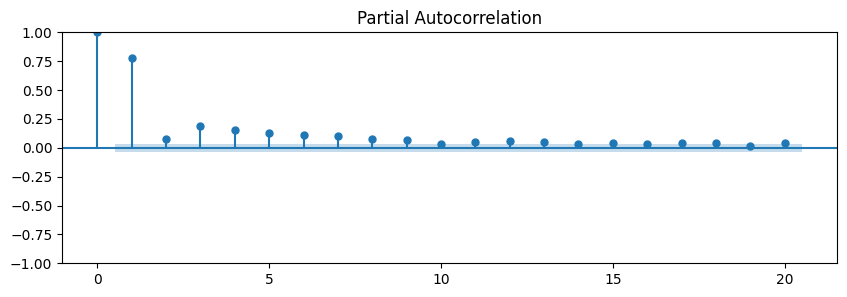

In [178]:
plot_pacf(series1.temp, lags = 20)
pyplot.show()

In [179]:
series1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3650 non-null   object 
 1   temp    3650 non-null   float64
dtypes: float64(1), object(1)
memory usage: 57.2+ KB


In [180]:
# Використовуємо модель ARIMA

src_data_model = series1.temp[:2920]
model = sa.tsa.ARIMA(src_data_model).fit()

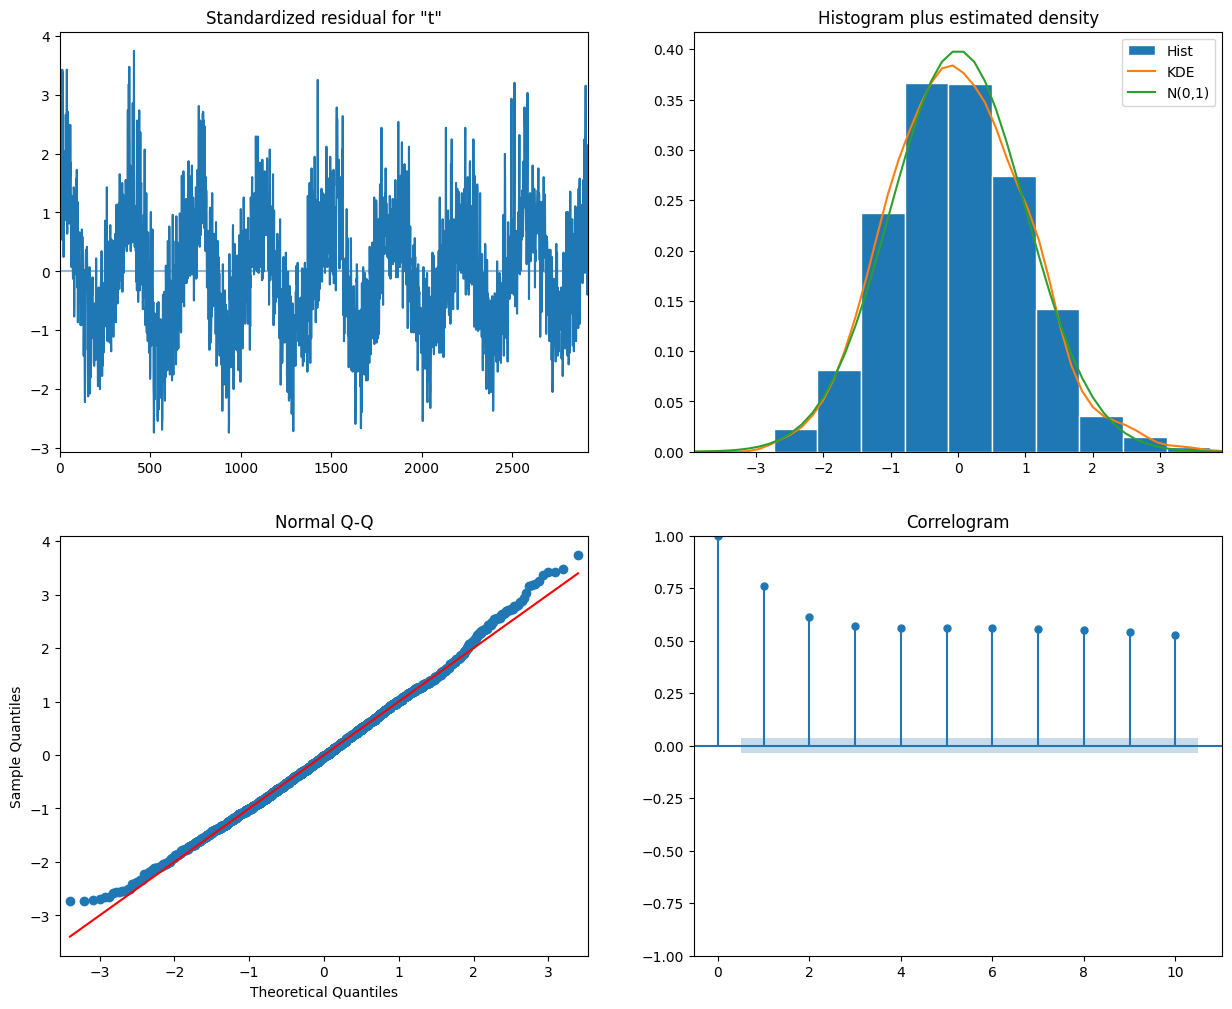

In [181]:
# Оцінимо нашу модель за допомогою графіків

fig = model.plot_diagnostics(figsize=(15,12))

In [182]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   temp   No. Observations:                 2920
Model:                          ARIMA   Log Likelihood               -8234.696
Date:                Tue, 14 Mar 2023   AIC                          16473.391
Time:                        15:47:55   BIC                          16485.350
Sample:                             0   HQIC                         16477.699
                               - 2920                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.1057      0.076    146.442      0.000      10.957      11.254
sigma2        16.4829      0.430     38.335      0.000      15.640      17.326
===================================================================================
Ljung-Box (L1) (Q):                1701.04   Jarque-Bera (JB):                18.79
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [183]:
pred = model.predict(2920,3649, typ='levels')

<AxesSubplot: >

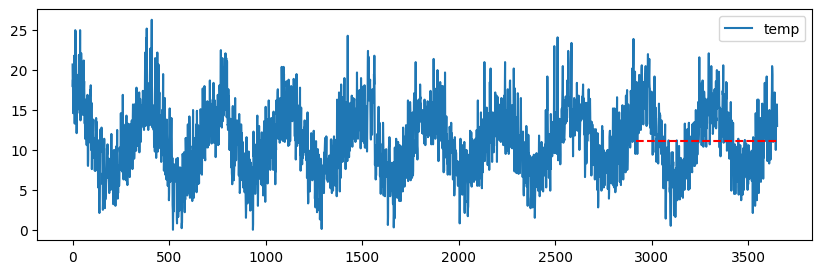

In [184]:
series1.plot()
pred.plot(style='r--')

In [185]:
comp = series1.temp[2919:3649]

In [186]:
mae_test_a = mean_absolute_error(comp, pred)
rmse_test_a = np.sqrt(mean_squared_error(comp, pred))
mape_test_a = mean_absolute_percentage_error(comp, pred)

print(f'MAE test: {mae_test_a: .2f}\n'
      f'RMSE test: {rmse_test_a: .2f}\n'
      f'MAPE test:{mape_test_a: .2f}')

MAE test:  3.40
RMSE test:  4.12
MAPE test: 0.43


In [187]:
# Застосовуємо модель SARIMAX

model = sa.tsa.statespace.SARIMAX(src_data_model, seasonal_order=(2,2,2,12)).fit()

In [188]:
pred = model.predict(2920,3649, typ='levels')

<AxesSubplot: >

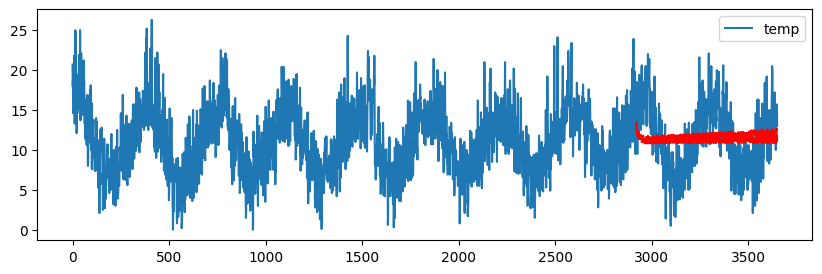

In [189]:
series1.plot()
pred.plot(style='r--')

In [150]:
mae_test_a1 = mean_absolute_error(comp, pred)
rmse_test_a1 = np.sqrt(mean_squared_error(comp, pred))
mape_test_a1 = mean_absolute_percentage_error(comp, pred)

print(f'MAE test: {mae_test_a: .2f}\n'
      f'RMSE test: {rmse_test_a: .2f}\n'
      f'MAPE test:{mape_test_a: .2f}')

MAE test:  3.40
RMSE test:  4.12
MAPE test: 0.43


### Висновки

Після оцінки моделей для наших 2х датасетів можемо зробити певні висновки. 

Якщо порівнювати графіки моделі ARIMA та SARIMAX для однакового датасету, то вони мають приблизно однаковий вигляд, але як на мене деякі графіки моделі SARIMAX трохи кращі. 

Якщо оцінювати метрики для однакового датасету, то вони відрізняються, але незначно. 

Якщо порівнювати моделі датасетів AirPassengers та temperature, то можемо порівняти показник mean_absolute_percentage_error. 

Для датасету AirPassengers - MAPE test: 0.11

Для датасету temperature - MAPE test: 0.43

Як ми бачимо, цей показник краще у моделей з датасету AirPassengers.

Для оцінки метрик я не зміг використати модуль ml_metrics, він не запускається в мене в Jupyter notebook.